In [1]:
from glotaran_tools.specification_parser import parse_yml
from glotaran_core.model import Dataset
from glotaran_models.kinetic import KineticSeperableModel
import numpy as np
from lmfit import Parameters
# Imports for plotting

import matplotlib.pyplot as plt
%matplotlib notebook

test_parameter = [101e-4, 1, 10]
test_amps = [1,2,3]
times = np.asarray(np.arange(-50, 1500, 1.5))

fitspec = '''
type: kinetic

parameter: {}

compartments: [s1, s2, s3]

megacomplexes:
    - label: mc1
      k_matrices: [k1]
      
k_matrices:
  - label: "k1"
    matrix: {{
      '("s1","s1")': 1,
}}

irf:
  - label: irf1
    type: gaussian
    center: 2
    width: 3
datasets: 
  - label: dataset1
    type: spectral
    megacomplexes: [mc1]
    path: 'data/dataset1.ascii'
    irf: irf1

'''
model = parse_yml(fitspec.format(test_parameter))
print(model)

Modeltype: Kinetic

Parameter
---------

Index: 1 Initial Value: 0.0101 Label: None
Index: 2 Initial Value: 1.0 Label: None
Index: 3 Initial Value: 10.0 Label: None

Megacomplexes
-------------

Label: mc1
K-Matrices: ['k1']

Datasets
--------

Dataset 'dataset1'

	Dataset Scaling: None
	Initial Concentration: None
	Megacomplexes: ['mc1']

	Irf: irf1


K-Matrices
----------

Label: k1
Matrix:
[[1]]


IRFs
----

Label: irf1 Type: 'Gaussian' Center: [2] Width: [3] Center Dispersion: [] Width Dispersion [] Scale: [], Nomalize: True



In [2]:
simparams = Parameters()
simparams.add("p1", 301e-5)
#simparams.add("p2",802e-5)
#simparams.add("p3",505e-5)
simparams.add("p2",0.3)
simparams.add("p3",21.4)
simparams.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr
p1   0.00301     -inf      inf     None     True     None
p2       0.3     -inf      inf     None     True     None
p3      21.4     -inf      inf     None     True     None


In [3]:
fitmodel = KineticSeperableModel(model)
fitmodel.get_initial_fitting_parameter().pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr
p1    0.0101     -inf      inf     None     True     None
p2         1     -inf      inf     None     True     None
p3        10     -inf      inf     None     True     None


<IPython.core.display.Javascript object>


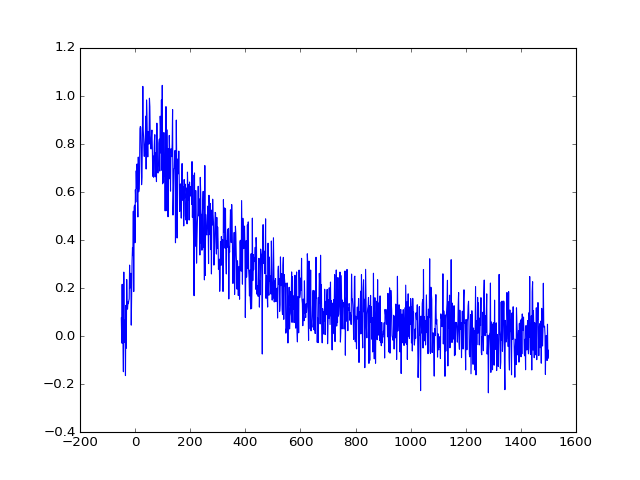

In [4]:
data = fitmodel.eval(simparams, *times, **{'dataset':'dataset1', 'noise':True, 'noise_std_dev':0.1})

fig = plt.figure()
plt.plot(times, data[:, 0])

In [5]:
result = fitmodel.fit(fitmodel.get_initial_fitting_parameter(), 
                      *times, 
                      **{"data": data}
                     )
result.best_fit_parameter.pretty_print()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1911e+01                                    2.06e+03    
       1              3         1.6596e+01      5.31e+00       1.12e+00       1.44e+04    
       2              4         6.7520e+00      9.84e+00       1.12e+00       3.76e+03    
       3              5         5.3278e+00      1.42e+00       2.23e+00       3.43e+02    
       4              6         5.1730e+00      1.55e-01       4.47e+00       1.48e+01    
       5              7         5.1299e+00      4.31e-02       4.06e+00       3.41e+00    
       6              8         5.1286e+00      1.32e-03       7.69e-01       7.41e-01    
       7              9         5.1286e+00      2.53e-05       1.08e-01       1.03e-01    
       8             10         5.1286e+00      4.69e-07       1.47e-02       1.42e-02    
       9             11         5.1286e+00      8.69e-09       2.02e-03       1.99e-03    

Fitted Amplitudes: [[ 1.0159951]]


<IPython.core.display.Javascript object>


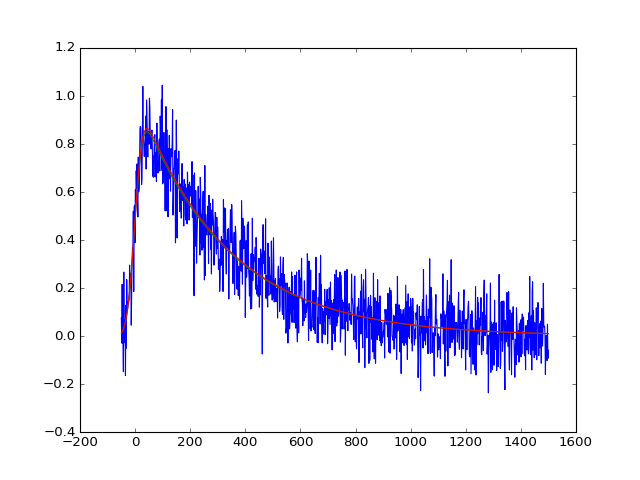

In [6]:
fitted_data = fitmodel.eval(result.best_fit_parameter, *times, **{'dataset':'dataset1'})
reconstructed_data = result.eval(*times, **{"data": data})
print('Fitted Amplitudes: {}'.format(result.e_matrix(*times, **{"data": data})))

fig = plt.figure()
plt.plot(times, data[:, 0])
plt.plot(times, fitted_data[:, 0])
plt.plot(times, reconstructed_data[:, 0])